# EPIC016: Isolation Forest modelo final

## 1.Importación de librerías

In [16]:
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
#import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

#Mostrar todas las columnas de un dataframe
pd.set_option('display.max_columns', None)

import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

## 2. Importación data

In [2]:
#Seleccionar ruta de la data
dataframe = pd.read_csv(r'../data/modeling/01_raw.csv', encoding='latin')
dataframe.shape

(52568, 12)

## 3. Feature engineering

In [3]:
#Cambio nombre de columna
dataframe.rename(columns = {'NUMPERIODO':'PERIODO'}, inplace = True)

#Creo variable FLG_ANSLBNP que es la unión de las variables FLG_AN y FLG_LSBNP
#Inicializo la variable en cero
dataframe['FLG_ANLSBNP']=0
#Creo las condicionales donde dependiendo de la  categoría de la variable inical pinto como 1
dataframe.loc[(dataframe.FLG_AN==1) & (dataframe.FLG_LSB_NP==1),'FLG_ANLSBNP' ] = 1
dataframe.loc[(dataframe.FLG_AN==1) & (dataframe.FLG_LSB_NP==0),'FLG_ANLSBNP' ] = 1
dataframe.loc[(dataframe.FLG_AN==0) & (dataframe.FLG_LSB_NP==1),'FLG_ANLSBNP' ] = 1
#Creo variables dummy de los tipos de persona para luego analizarlo en el perfilamiento (No es parte del modelamiento esta variable)
data_dummies=pd.get_dummies(dataframe['TIPPER_AGRUP']).astype(int)
#Agrego las variables dummies creadas al dataframe original
dataframe = pd.concat([dataframe, data_dummies], axis = 1)

dataframe.shape

(52568, 16)

## 3. Universo

In [4]:
#Selecciono el periodo de modelamiento y monto de ingresos mayor a 1000
dataset=dataframe.loc[(dataframe['PERIODO']>=202203) & (dataframe['PERIODO']<=202207) & (dataframe['MTO_INGRESOS']>1000)]
dataset.shape

(28680, 16)

In [5]:
dataset.to_csv(r'../data/modeling/02_train_preprocessed.csv',index=False,sep='|')

In [6]:
#No necesario por poca data
# datasample=dataset.sample(n=20000, random_state=7)
# datasample.shape

## 4. Análisis de datos

In [7]:
#Reviso columnas
dataset.columns

Index(['PERIODO', 'CODCLAVECIC', 'TIPPER_AGRUP', 'MTO_INGRESOS', 'MTO_EGRESOS',
       'RATIO_ING_TOT', 'POR_CASH', 'FLG_PERFIL_3DESVT_TRX', 'FLG_AN',
       'FLG_LSB_NP', 'MEDIA_DEP', 'DESV_DEP', 'FLG_ANLSBNP', 'PJ', 'PN_CN',
       'PN_SN'],
      dtype='object')

### Modelo 1: Todas las variables

In [19]:
#Variable
a=['MTO_INGRESOS', 'MTO_EGRESOS','RATIO_ING_TOT', 'POR_CASH', 'FLG_PERFIL_3DESVT_TRX', 'FLG_ANLSBNP']

#Modelo base IF
ds=dataset[a]
clf_base = IsolationForest(n_estimators = 500, contamination=0.1,random_state=7)
clf_base.fit(ds)

#score de silueta
datasetv1 = dataset.copy()
datasetv1['IF_LABEL']=clf_base.predict(ds)
scoreSilhoutte = metrics.silhouette_score(ds, datasetv1['IF_LABEL'], metric='euclidean')  
print('Silueta:',scoreSilhoutte)

#Casos estimados
ds=dataset[a]
datasetv2 = dataset.copy()
datasetv2['IF_LABEL']=clf_base.predict(ds)
datasetv2.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.6446430121066279


PERIODO  IF_LABEL
202203   -1           608
          1          4962
202204   -1           519
          1          5129
202205   -1           557
          1          5186
202206   -1           583
          1          5244
202207   -1           601
          1          5291
dtype: int64

### Modelo 2: Todas las variables y bajando contaminación a 0.05

In [20]:
#Variable
a=['MTO_INGRESOS', 'MTO_EGRESOS','RATIO_ING_TOT', 'POR_CASH', 'FLG_PERFIL_3DESVT_TRX', 'FLG_ANLSBNP']

#Modelo base IF
ds=dataset[a]
clf_base = IsolationForest(n_estimators = 500, contamination=0.05,random_state=7)
clf_base.fit(ds)

#score de silueta
datasetv1 = dataset.copy()
datasetv1['IF_LABEL']=clf_base.predict(ds)
scoreSilhoutte = metrics.silhouette_score(ds, datasetv1['IF_LABEL'], metric='euclidean') 
print('Silueta:',scoreSilhoutte)

#Casos estimados
ds=dataset[a]
datasetv2 = dataset.copy()
datasetv2['IF_LABEL']=clf_base.predict(ds)
datasetv2.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.7500615372252972


PERIODO  IF_LABEL
202203   -1           281
          1          5289
202204   -1           255
          1          5393
202205   -1           277
          1          5466
202206   -1           283
          1          5544
202207   -1           338
          1          5554
dtype: int64

### Model 3: Todas las variables sin MTO_EGRESO

In [21]:
#Variable
a=['MTO_INGRESOS', 'RATIO_ING_TOT', 'POR_CASH', 'FLG_PERFIL_3DESVT_TRX', 'FLG_ANLSBNP']

#Modelo base IF
ds=dataset[a]
clf_base = IsolationForest(n_estimators = 500, contamination=0.05,random_state=7)
clf_base.fit(ds)

#score de silueta
datasetv1 = dataset.copy()
datasetv1['IF_LABEL']=clf_base.predict(ds)
scoreSilhoutte = metrics.silhouette_score(ds, datasetv1['IF_LABEL'], metric='euclidean')
print('Silueta:',scoreSilhoutte)

#Casos estimados
ds=dataset[a]
datasetv2 = dataset.copy()
datasetv2['IF_LABEL']=clf_base.predict(ds)
datasetv2.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.7192429888213406


PERIODO  IF_LABEL
202203   -1           272
          1          5298
202204   -1           262
          1          5386
202205   -1           268
          1          5475
202206   -1           289
          1          5538
202207   -1           342
          1          5550
dtype: int64

### Model 4: Todas las variables usadas en el modelo K-Means final

In [22]:
#Variable
a=['MTO_INGRESOS', 'POR_CASH', 'FLG_PERFIL_3DESVT_TRX', 'FLG_ANLSBNP']

#Modelo base IF
ds=dataset[a]
clf_base = IsolationForest(n_estimators = 500, contamination=0.05,random_state=7)
clf_base.fit(ds)

#score de silueta
datasetv1 = dataset.copy()
datasetv1['IF_LABEL']=clf_base.predict(ds)
scoreSilhoutte = metrics.silhouette_score(ds, datasetv1['IF_LABEL'], metric='euclidean')
print('Silueta:',scoreSilhoutte)

#Casos estimados
ds=dataset[a]
datasetv2 = dataset.copy()
datasetv2['IF_LABEL']=clf_base.predict(ds)
datasetv2.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.7304843261735888


PERIODO  IF_LABEL
202203   -1           248
          1          5322
202204   -1           264
          1          5384
202205   -1           275
          1          5468
202206   -1           292
          1          5535
202207   -1           355
          1          5537
dtype: int64

### Model 5: Todas las variables usadas en el modelo K-Means final + variable RATIO

In [23]:
#Variable
a=['MTO_INGRESOS', 'RATIO_ING_TOT','POR_CASH', 'FLG_PERFIL_3DESVT_TRX', 'FLG_ANLSBNP']

#Modelo base IF
ds=dataset[a]
clf_base = IsolationForest(n_estimators = 500, contamination=0.01,random_state=7)
clf_base.fit(ds)

#score de silueta
datasetv1 = dataset.copy()
datasetv1['IF_LABEL']=clf_base.predict(ds)
scoreSilhoutte = metrics.silhouette_score(ds, datasetv1['IF_LABEL'], metric='euclidean')  
print('Silueta:',scoreSilhoutte)

#Casos estimados
ds=dataset[a]
datasetv2 = dataset.copy()
datasetv2['IF_LABEL']=clf_base.predict(ds)
datasetv2.groupby(['PERIODO','IF_LABEL']).size()

Silueta: 0.8099008994793859


PERIODO  IF_LABEL
202203   -1            42
          1          5528
202204   -1            57
          1          5591
202205   -1            40
          1          5703
202206   -1            69
          1          5758
202207   -1            79
          1          5813
dtype: int64

### Model 6: Variables de Model Test 5 pero con contaminación 0.005 (MODELO FINAL)

In [ ]:
#Variable
a=['MTO_INGRESOS', 'RATIO_ING_TOT','POR_CASH', 'FLG_PERFIL_3DESVT_TRX', 'FLG_ANLSBNP']

#Modelo base IF
ds=dataset[a]
clf_base = IsolationForest(n_estimators = 500, contamination=0.005,random_state=7)
clf_base.fit(ds)

#score de silueta
datasetv1 = dataset.copy()
datasetv1['IF_LABEL']=clf_base.predict(ds)
scoreSilhoutte = metrics.silhouette_score(ds, datasetv1['IF_LABEL'], metric='euclidean')  
print('Silueta:',scoreSilhoutte)

#Casos estimados
ds=dataset[a]
datasetv2 = dataset.copy()
datasetv2['IF_LABEL']=clf_base.predict(ds)
datasetv2.groupby(['PERIODO','IF_LABEL']).size()

In [10]:
#REviso el total de outliers
datasetv1.groupby(['IF_LABEL']).size()

IF_LABEL
-1      144
 1    28536
dtype: int64

In [11]:
#Copio a excel tabla de medias por grupo
datasetv1.groupby('IF_LABEL').mean().round(3).to_clipboard(excel=True)

In [27]:
#Tabla de medias por grupo
datasetv1.groupby('IF_LABEL').mean().round(3)

,PERIODO,CODCLAVECIC,MTO_INGRESOS,MTO_EGRESOS,RATIO_ING_TOT,POR_CASH,FLG_PERFIL_3DESVT_TRX,FLG_AN,FLG_LSB_NP,MEDIA_DEP,DESV_DEP,FLG_ANLSBNP
IF_LABEL,,,,,,,,,,,,
-1,202205.465,1.727763e+07,613070.849,123893.240,0.459,0.696,0.646,0.583,0.535,222869.635,114125.584,0.722
1,202205.026,1.496480e+07,75669.613,27859.478,0.544,0.022,0.132,0.217,0.295,60221.776,33441.407,0.392


In [12]:
#Exporto a excel tabla scoreada
datasetv1.to_excel(r'IF_MEpic16.xlsx',index=False,header=True)

### Modelo 7 : FINAL

In [8]:
#Variable
a=['MTO_INGRESOS', 'POR_CASH', 'FLG_PERFIL_3DESVT_TRX', 'FLG_ANLSBNP']

#Modelo base IF
ds=dataset[a].copy()
clf_base = IsolationForest(n_estimators = 500, contamination=0.005,random_state=7,max_features=4)
clf_base.fit(ds)

#score de silueta
datasetv1 = dataset.copy()
datasetv1['IF_LABEL']=clf_base.predict(ds)
scoreSilhoutte = metrics.silhouette_score(ds, datasetv1['IF_LABEL'], metric='euclidean')
print('Silueta:',scoreSilhoutte)

Silueta: 0.8891759007880911


In [9]:

#Casos estimados
ds=dataset[a]
datasetv2 = dataset.copy()
datasetv2['IF_LABEL']=clf_base.predict(ds)
datasetv2.groupby(['PERIODO','IF_LABEL']).size()

PERIODO  IF_LABEL
202203   -1            12
          1          5558
202204   -1            31
          1          5617
202205   -1            19
          1          5724
202206   -1            38
          1          5789
202207   -1            44
          1          5848
dtype: int64

In [19]:
datasetv2.to_csv(r'../data/modeling/03_train_output.csv',index=False)

In [11]:
#Guardar el modelo
model_output = r'../src/03_models/IF_MEpic16v2.model'
pickle.dump(clf_base, open(model_output, 'wb'))

In [12]:
#Valido total de outliers
datasetv1.groupby(['IF_LABEL']).size()

IF_LABEL
-1      144
 1    28536
dtype: int64

In [13]:
#Copio a excel tabla de medias por grupo
datasetv1.groupby('IF_LABEL').mean().round(3).to_clipboard(excel=True)

In [14]:
#Tabla de medias por grupo
datasetv1.groupby('IF_LABEL').mean().round(3)

,PERIODO,CODCLAVECIC,MTO_INGRESOS,MTO_EGRESOS,RATIO_ING_TOT,POR_CASH,FLG_PERFIL_3DESVT_TRX,FLG_AN,FLG_LSB_NP,MEDIA_DEP,DESV_DEP,FLG_ANLSBNP,PJ,PN_CN,PN_SN
IF_LABEL,,,,,,,,,,,,,,,
-1,202205.493,1.750069e+07,860242.105,172487.366,0.574,0.635,0.660,0.556,0.562,442942.267,150670.588,0.722,0.250,0.049,0.701
1,202205.026,1.496367e+07,74422.324,27614.259,0.544,0.022,0.132,0.217,0.295,59111.233,33256.992,0.392,0.052,0.164,0.784


In [16]:
#Exporto a excel la tabla scoreada
datasetv1.to_excel(r'../data/modeling/tmp/IF_MEpic16_v2.xlsx',index=False,header=True)

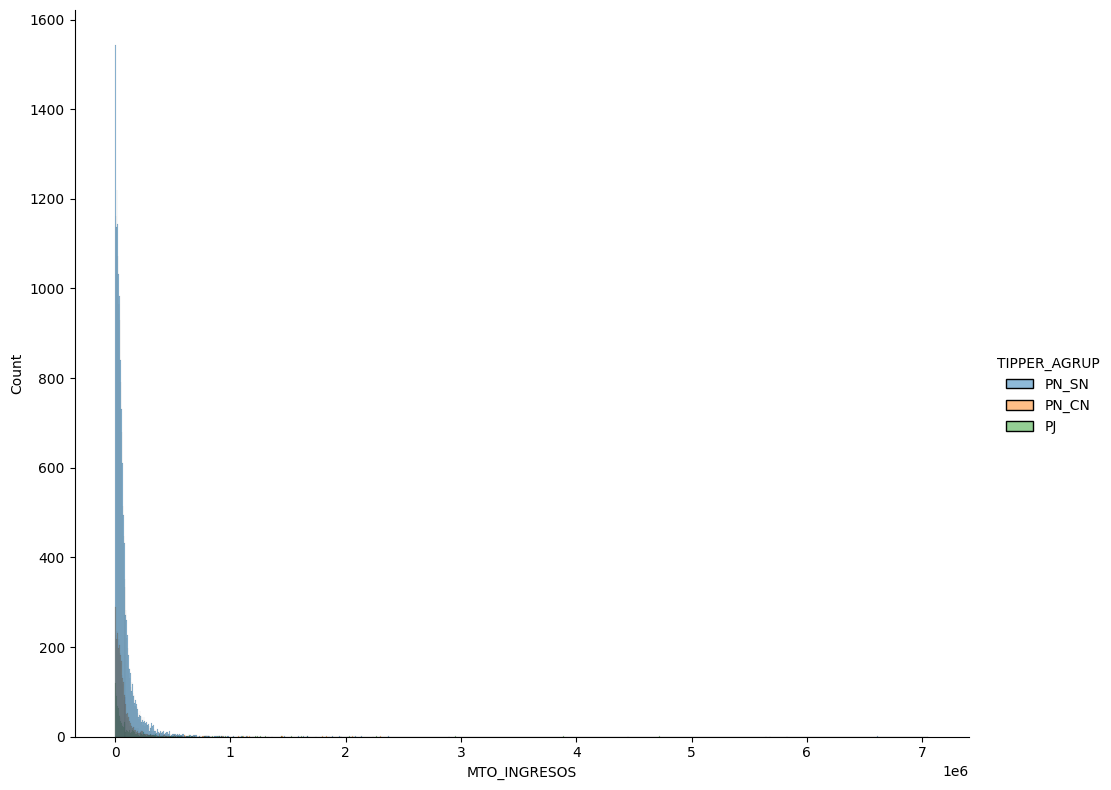

In [17]:
#Valido distribución por tipo de persona
sns.displot(dataset, x='MTO_INGRESOS', hue='TIPPER_AGRUP',height = 8, aspect = 1.25)

<AxesSubplot: xlabel='MTO_INGRESOS', ylabel='TIPPER_AGRUP'>

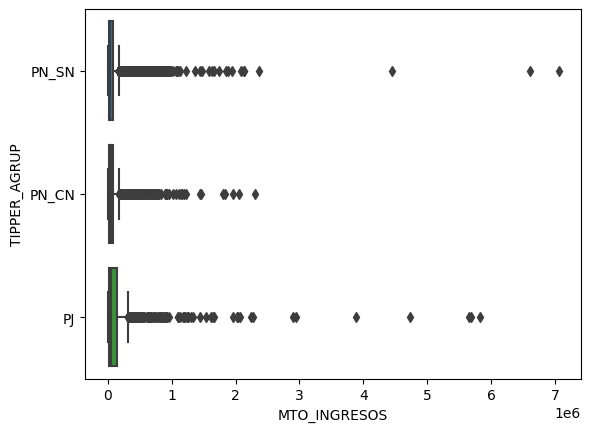

In [18]:
#Boxplot para ver la distribución del monto por tipo de persona
sns.boxplot(x="MTO_INGRESOS",  y="TIPPER_AGRUP", data=dataset)